In [1]:
import torch
import gecco_torch
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from einops import rearrange
from torch import Tensor
from torch.utils.data import DataLoader

ModuleNotFoundError: No module named 'gecco_torch'

In [15]:
config = gecco_torch.load_config('../example_configs/train_joints.py')
data: pl.LightningDataModule = config.data
data.setup() # lightning data modules need to be setup before they can be used

num steps: 2000000, batch size: 48, save_every: 10000, epoch size: 480000, num epochs: 200


  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

In [16]:
batches = []

dataloader: DataLoader = data.train_dataloader()

for i, batch in enumerate(dataloader):
    if i == 5: # break early to save time
        break
    batches.append(batch)

batches: gecco_torch.structs.Example = dataloader.collate_fn(batches) # [5, batch_size, ...]
batches = batches.apply_to_tensors(lambda t: t.reshape(-1, *t.shape[2:])) # [5 * batch_size, ...]

In [17]:
batches

Example(
 data=(240, 100, 3),
 ctx=Context3d(
   image=(240, 3, 1024, 1024),
   K=(240, 3, 3),
 )
)

In [18]:
placeholder_reparam = gecco_torch.reparam.GaussianReparam(
   mean=torch.zeros(3),
   sigma=torch.ones(3),
)

# placeholder_reparam = gecco_torch.reparam.UVLReparam(
#     mean=torch.zeros(3),
#     sigma=torch.ones(3),
# )

diff_placeholder = placeholder_reparam.data_to_diffusion(batches.data, batches.ctx)

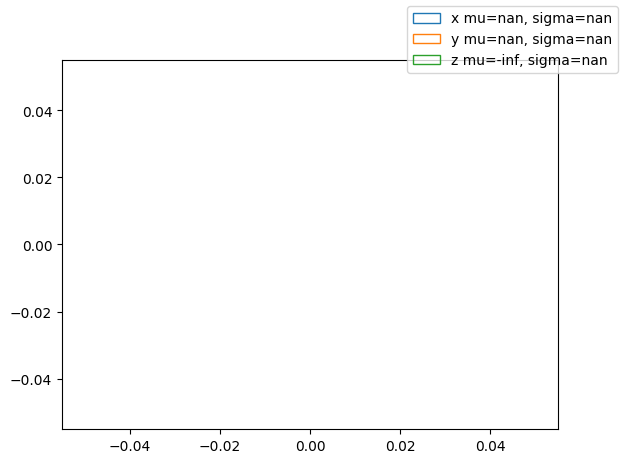

In [19]:
def data_statistics(data: Tensor) -> tuple[Tensor, Tensor]:
    x, y, z = data.unbind(-1)
    fig, ax = plt.subplots()
    kw = dict(histtype='step', bins=torch.linspace(data.min(), data.max(), 100))
    ax.hist(x.flatten(), label=f'x mu={x.mean().item():.02f}, sigma={x.std().item():0.2f}', **kw)
    ax.hist(y.flatten(), label=f'y mu={y.mean().item():.02f}, sigma={y.std().item():0.2f}', **kw)
    ax.hist(z.flatten(), label=f'z mu={z.mean().item():.02f}, sigma={z.std().item():0.2f}', **kw)
    fig.legend()

    mean = data.mean(dim=(0, 1))
    sigma = data.std(dim=(0, 1))

    return mean, sigma

mean_raw, sigma_raw = data_statistics(diff_placeholder)

In [7]:
adjusted_reparam = gecco_torch.reparam.GaussianReparam(mean=mean_raw, sigma=sigma_raw)
# adjusted_reparam = gecco_torch.reparam.UVLReparam(mean=mean_raw, sigma=sigma_raw)
print(adjusted_reparam)

GaussianReparam(mean=[nan, nan, -inf], sigma=[nan, nan, nan])


(tensor([ 4.1779e-09, -6.0499e-09, -2.0742e-08]), tensor([1., 1., 1.]))

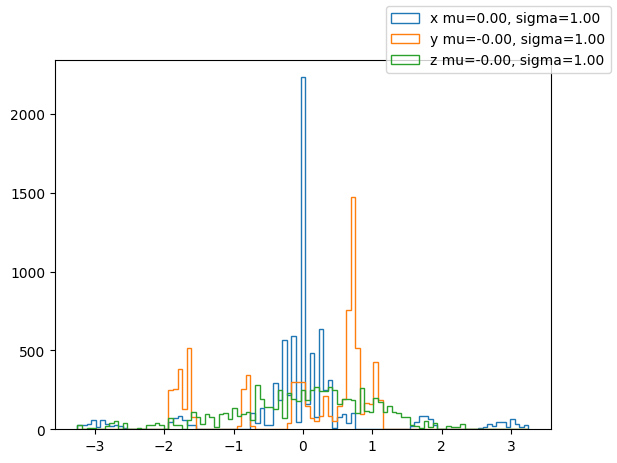

In [13]:
diff_adjusted = adjusted_reparam.data_to_diffusion(batches.data, batches.ctx)

data_statistics(diff_adjusted)

In [ ]:
diff_flat = rearrange(diff_adjusted, 'b n d -> b (n d)')

distm = torch.cdist(diff_flat, diff_flat)
print(f'The value to use for sigma_max of your noise schedule is {distm.max().item()}.')
_ = plt.hist(distm.flatten()) # show a histogram of the distances for better intuition